In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
xls = pd.ExcelFile('Online Retail Clean.xlsx')
df = pd.read_excel(xls, 'Sheet1')
df.shape

(354345, 9)

In [62]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [63]:
df.dtypes

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalAmount           float64
dtype: object

In [64]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [65]:
latest_date = dt.datetime(2011,12,10)

In [66]:
rfmscores = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latest_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})


In [67]:
rfmscores.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalAmount': 'Monetary'}, inplace=True)


In [68]:
rfmscores['Recency'] = rfmscores['Recency'].astype(int)

In [69]:
rfmscores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,103,4196.01
2,12748,0,4596,33719.73
3,12749,3,199,4090.88
4,12820,3,59,942.34


In [70]:
rfmscores.dtypes

Recency        int64
Frequency      int64
Monetary     float64
dtype: object

In [71]:
rfmscores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

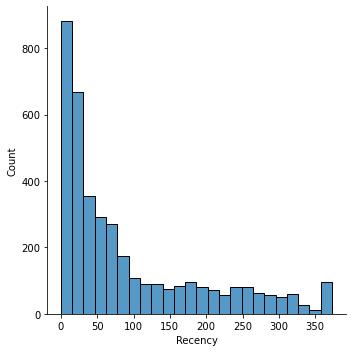

In [72]:
x = rfmscores['Recency']

ax = sns.displot(x)

In [73]:
rfmscores.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

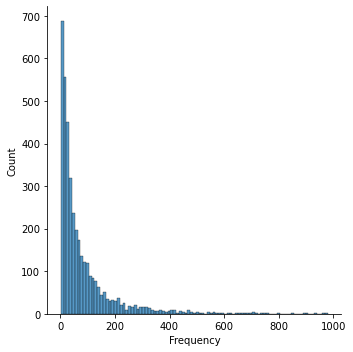

In [74]:
x = rfmscores.query('Frequency < 1000')['Frequency']

ax = sns.displot(x)

In [75]:
rfmscores.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

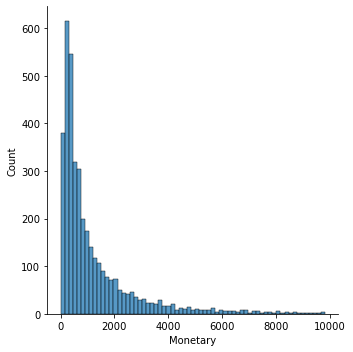

In [76]:
x = rfmscores.query('Monetary < 10000')['Monetary']

ax = sns.displot(x)

In [77]:
quantiles = rfmscores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [78]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [79]:
#Functions for R, F & M Segments

#More recent (lower recency) is better
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <=d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

#More frequent and higher value (higher frequency and monetary) is better
def FMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <=d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1


In [80]:
rfmscores ['R'] = rfmscores['Recency'].apply(RScoring, args=('Recency', quantiles))
rfmscores ['F'] = rfmscores['Frequency'].apply(FMScoring, args=('Frequency', quantiles))
rfmscores ['M'] = rfmscores['Monetary'].apply(FMScoring, args=('Monetary', quantiles))
rfmscores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,325,1,77183.60,4,4,1
12747,2,103,4196.01,1,1,1
12748,0,4596,33719.73,1,1,1
12749,3,199,4090.88,1,1,1
12820,3,59,942.34,1,2,2


In [81]:
rfmscores['Group'] = rfmscores.R.map(str)+rfmscores.F.map(str)+rfmscores.M.map(str)
rfmscores['Score'] = rfmscores[['R','F','M']].sum(axis = 1)
rfmscores.head()

,Recency,Frequency,Monetary,R,F,M,Group,Score
CustomerID,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9
12747,2,103,4196.01,1,1,1,111,3
12748,0,4596,33719.73,1,1,1,111,3
12749,3,199,4090.88,1,1,1,111,3
12820,3,59,942.34,1,2,2,122,5


In [82]:
Cust_Tier = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_Slices = pd.qcut(rfmscores.Score, q = 4, labels = Cust_Tier)
rfmscores['Customer_Tier'] = Score_Slices.values
rfmscores.head()

,Recency,Frequency,Monetary,R,F,M,Group,Score,Customer_Tier
CustomerID,,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9,Silver
12747,2,103,4196.01,1,1,1,111,3,Platinum
12748,0,4596,33719.73,1,1,1,111,3,Platinum
12749,3,199,4090.88,1,1,1,111,3,Platinum
12820,3,59,942.34,1,2,2,122,5,Platinum


In [83]:
rfmscores.shape

(3921, 9)

In [84]:
graph = rfmscores.query("Monetary < 50000 and Frequency < 2000")


In [85]:

plot_data = [
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Bronze'")['Recency'],
        y=graph.query("Customer_Tier == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Silver'")['Recency'],
        y=graph.query("Customer_Tier == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Gold'")['Recency'],
        y=graph.query("Customer_Tier == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Platinum'")['Recency'],
        y=graph.query("Customer_Tier == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [86]:

plot_data = [
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Bronze'")['Frequency'],
        y=graph.query("Customer_Tier == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Silver'")['Frequency'],
        y=graph.query("Customer_Tier == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Gold'")['Frequency'],
        y=graph.query("Customer_Tier == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Platinum'")['Frequency'],
        y=graph.query("Customer_Tier == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


In [87]:

plot_data = [
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Bronze'")['Recency'],
        y=graph.query("Customer_Tier == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Silver'")['Recency'],
        y=graph.query("Customer_Tier == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("Customer_Tier == 'Gold'")['Recency'],
        y=graph.query("Customer_Tier == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("Customer_Tier == 'Platinum'")['Recency'],
        y=graph.query("Customer_Tier == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [88]:
rfmscores.to_excel('Online Customer Tiers.xlsx', index = False)